# Setup

In [44]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.spatial import ConvexHull

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

base_df = pd.read_csv("data_2.csv", index_col=0)

Encode categorical attribute industry with one hot encoder

In [17]:
one_hot_df = pd.get_dummies(base_df, prefix='industry')
one_hot_df

,revenues,ebit,employees,market_cap,outstanding_shares,stock_price,industry_automobiles,industry_finance,industry_technology
0,9.894661e+10,3.368791e+10,39161.284575,8.610166e+11,8.920990e+09,98.094205,0,0,1
1,8.989423e+10,5.421196e+10,NaN,1.169811e+12,1.817962e+10,64.925081,0,0,1
2,8.783573e+10,4.223690e+10,86764.936060,7.737738e+11,6.672160e+09,120.558326,0,0,1
3,7.903555e+10,2.921541e+10,157253.941191,6.624233e+11,4.560541e+09,148.060378,0,0,1
4,7.531216e+10,3.333325e+10,85562.800295,6.352531e+11,1.253771e+10,50.603175,0,0,1
...,...,...,...,...,...,...,...,...,...
745,4.367233e+10,2.770794e+10,25275.189008,5.527104e+11,2.663421e+10,21.238552,1,0,0
746,5.439364e+10,3.002825e+10,126636.471476,2.344987e+11,1.828919e+09,127.065020,1,0,0
747,5.089252e+10,3.439496e+10,160595.850319,8.319590e+11,1.913342e+10,44.512984,1,0,0
748,4.411272e+10,2.596733e+10,16250.395261,2.355543e+11,2.298825e+09,102.313825,1,0,0


# Multivariate Outliers?

Check for multivariate normality (QQ plot for Chi-Square distribution)

In [32]:
# check for multivariate normality
# df = degrees of freedom = 4 (4 features)
deg_f = len(one_hot_df.columns)

# Calculate the mean
cm = one_hot_df.mean()
# covariance matrix
S = one_hot_df.cov()

# Complete Case analysis for now (otherwise squared distances are also Null)
data = one_hot_df.dropna().copy()
# Calculate the squared distance row-wise
d = one_hot_df.apply(lambda x: np.dot(np.dot(x - cm, np.linalg.inv(S)), (x - cm)), axis=1)

In [33]:
data['sorted_d'] = d
data = data.sort_values(by='sorted_d')

In [34]:
# Get the theoretical quantile value for each observed one
n = len(data)
data['qc']= [chi2.ppf((i - 0.5) / n, df=deg_f) for i in range(1, n + 1)]
data

,revenues,ebit,employees,market_cap,outstanding_shares,stock_price,industry_automobiles,industry_finance,industry_technology,sorted_d,qc
630,4.384530e+10,3.290080e+10,73351.162996,4.877735e+11,5.959482e+09,80.596939,1,0,0,1.767773,1.061717
706,4.604910e+10,3.115650e+10,84452.322725,4.214078e+11,3.710090e+09,117.122685,1,0,0,1.829959,1.396401
711,4.632546e+10,2.831669e+10,38454.739169,4.424520e+11,6.831648e+09,64.573918,1,0,0,1.846376,1.591648
661,4.724173e+10,3.019457e+10,31102.161481,5.313669e+11,8.028871e+09,66.393346,1,0,0,1.966413,1.737546
546,4.354192e+10,3.221326e+10,22495.816381,5.483834e+11,1.092870e+10,50.782162,1,0,0,1.973915,1.856831
...,...,...,...,...,...,...,...,...,...,...,...
147,9.624478e+10,6.127217e+10,35393.446327,4.619850e+11,2.575696e+09,177.206452,0,0,1,28.788767,22.882564
75,8.926226e+10,6.769616e+10,91225.485738,8.185361e+11,6.802735e+10,11.887972,0,0,1,29.600673,23.573670
268,2.946955e+10,2.684491e+07,859566.486663,3.517926e+08,9.784065e+06,36.968714,0,1,0,40.933185,24.488746
455,2.952457e+10,2.243936e+09,915990.769652,1.220087e+10,1.663126e+08,75.422398,0,1,0,46.447458,25.857990


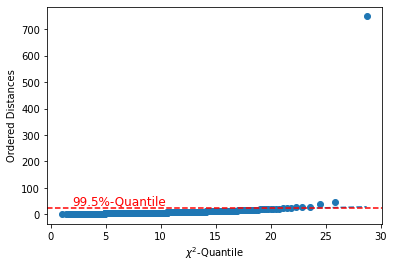

In [35]:
# plot theoretical and empirical quantiles
quantile_995 = chi2.ppf(1 - 0.005, df=deg_f)
plt.scatter(data['qc'], data['sorted_d'])
plt.plot(data['qc'], data['qc'], linestyle='--', label='y = x (slope 1)')
plt.xlabel(r'$\chi^2$-Quantile')
plt.ylabel('Ordered Distances')
plt.axhline(y=quantile_995, color='red', linestyle='--')
plt.text(2, quantile_995, '99.5%-Quantile', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

In [36]:
outlier = data[(data['sorted_d'] > 100)]
data = data[(data['sorted_d'] < 100)] 

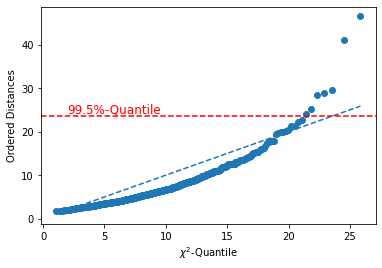

In [37]:
# plot theoretical and empirical quantiles
quantile_995 = chi2.ppf(1 - 0.005, df=deg_f)
plt.scatter(data['qc'], data['sorted_d'])
plt.plot(data['qc'], data['qc'], linestyle='--', label='y = x (slope 1)')
plt.xlabel(r'$\chi^2$-Quantile')
plt.ylabel('Ordered Distances')
plt.axhline(y=quantile_995, color='red', linestyle='--')
plt.text(2, quantile_995, '99.5%-Quantile', color='red', fontsize=12, verticalalignment='bottom')
plt.show()

The data does not seem to follow a multivariate normal distribution. However, one observation still seems to differ a lot from all other observations.

In [38]:
# show the outstanding observation
outlier

,revenues,ebit,employees,market_cap,outstanding_shares,stock_price,industry_automobiles,industry_finance,industry_technology,sorted_d,qc
72,7.106195e+10,3.512886e+10,3510.179599,8.591727e+11,1.212385e+14,0.007164,0,0,1,747.786166,28.734312


This definitely seems to be an outlier. Even from a univariate perspective this seems to be an outlier in all features.

# Apply angle based approach to find multivariate outliers

In [40]:
# Depth-based clustering
def outliers_depth_based(x, k=1):
    x['idx'] = list(range(len(x)))
    x['outlier'] = [False for _ in range(len(x))]
    volumes = {}
    for i in range(k):
        # Filter the dataset to contain only observations not classified as outliers yet.
        x_filtered = x[~x['outlier']]
        if len(x_filtered) < 3:
            break
        x_chull = x_filtered.iloc[:, :-2]
        hull = ConvexHull(x_chull)
        volumes[i+1] = hull.volume
        idx = x_filtered.iloc[hull.vertices, -2]
        x.loc[idx, 'outlier'] = True
    return x[x['outlier']].index, volumes

In [42]:
df = one_hot_df.loc[:, ['revenues', 'ebit']]
idx, volumes = outliers_depth_based(x=df, k=1)

In [43]:
# prepare for plotting
df['outlier'] = [False for _ in range(len(df))]
df.loc[idx, 'outlier'] = True

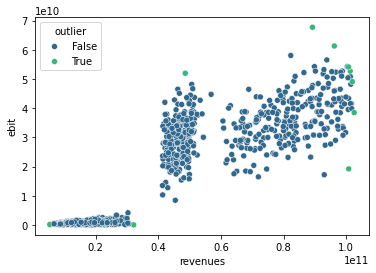

In [46]:
sns.scatterplot(data=df, x='revenues', y='ebit', hue='outlier', palette="viridis")
plt.xlabel('revenues')
plt.ylabel('ebit')
plt.show()